# Graph-UNets

Hereafter is the implementation of the paper https://arxiv.org/pdf/1905.05178v1.pdf, this is indeed the method chosen from the ones listed in the survey paper https://arxiv.org/pdf/2110.05292.pdf

To summarize the approach we composed a UNet, with its characteristical skip connections, after which we simply inserted a linear layer. Such topping allowed us to adoperate a method widely adopted for generation tasks to exploit it for graph classification.

In this experiment we adopted GraphConv as convolutional layer instead of GCNConv.
The decision was taken due to the recommendation in the pytorch geometric tutorial https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l.  
This library should indeed have the advantage of internal residual connections that help preserving information across the
convolution, which in turn is supposed to boost performances.

## Imports

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool, GraphConv
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [2]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](graphpool.png)

In [3]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        return xl1, edge_index_pooled, idx.squeeze()

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## Graph Unpooling

In [5]:
class gUnpool(nn.Module):
    """
    Our implementation of the unpooling methodology described in the paper
    """
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,idx,up_shape):
        up_nodes,C = up_shape #We extract the number of nodes and features the graph has to return to
        xl1=torch.zeros((up_nodes,xl.shape[1]), device = self.device)
        xl1[idx]=xl #We fetch the current feature matrix and sorround it of zeros to have the desired shape
        return xl1
        

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [6]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        self.in_conv = GraphConv(dataset.num_features, 16)
        
        self.GC1 = GraphConv(16, 32) 
        self.GC2 = GraphConv(32, 64)
        self.GC3 = GraphConv(64, 128)
        self.GC4 = GraphConv(128, 256)
        self.act=nn.ELU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.gUnpool1 = gUnpool(256, 128)
        self.gUnpool2 = gUnpool(128, 64)
        self.gUnpool3 = gUnpool(64, 32)
        self.gUnpool4 = gUnpool(32, 16)
        
        self.GC5 = GraphConv(256+128, 128) 
        self.GC6 = GraphConv(128+64, 64) 
        self.GC7 = GraphConv(64+32, 32)  
        self.GC8 = GraphConv(32+16, 16)
        
        self.out_conv = GraphConv(16, dataset.num_features)
        
        self.linear = nn.Linear(dataset.num_features, 1)
        
    
    def forward(self,x,edge_index,batch):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2 = self.gPool1(x1,edge_index)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3)
        
        #Pool2
        x4,  edge_index4, idx4 = self.gPool2(x3,edge_index2)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5)
        
        #Pool3
        x6,  edge_index6, idx6 = self.gPool3(x5,edge_index4)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7)
        
        #Pool4
        x8,  edge_index8, idx8 = self.gPool4(x7,edge_index6)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9)
        
        #Decoder
        
        #Unpool1
        x10 = self.gUnpool1(x9,idx8,x7.shape)
        x10 = torch.cat([x7, x10], dim=1) #Skip connection, an alternative would be to use the sum, i.e. #x10 = x7 + x10
        x10 = self.act(x10)
        
        x11 = self.GC5(x10, edge_index8)
        x11 = self.act(x11)
        
        #Unpool2
        x12 = self.gUnpool2(x11,idx6,x5.shape)
        x12 = torch.cat([x5, x12], dim=1)
        x12 = self.act(x12)
        
        x13 = self.GC6(x12, edge_index6)
        x13 = self.act(x13)
        
        #Unpool3
        x14 = self.gUnpool3(x13,idx4,x3.shape)
        x14 = torch.cat([x3, x14], dim=1)
        x14 = self.act(x14)
        
        x15 = self.GC7(x14, edge_index4)
        x15 = self.act(x15)
        
        #Unpool4
        x16 = self.gUnpool4(x15,idx2,x1.shape)
        x16 = torch.cat([x1, x16], dim=1)
        x16 = self.act(x16)
        
        x17 = self.GC8(x16, edge_index2)
        x17 = self.act(x17)
        
        
        x18 = self.out_conv(x17, edge_index)
        x18 = self.act(x18)
        
        #Readout
        x19 = global_mean_pool(x18, batch) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x19 = self.act(x19)
        
        #Linear
        x19=self.linear(x19)
        
        return x19

## Parameters customization

In [7]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet().to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [8]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average validation loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average validation accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.11it/s]


Training loss epoch 0:  0.6845967173576355
Training accuracy epoch 0:  0.55859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 0:  0.6682603359222412
Validation accuracy epoch 0:  0.5742574257425742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 1:  0.6896872371435165
Training accuracy epoch 1:  0.5673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


Validation loss epoch 1:  0.6458103060722351
Validation accuracy epoch 1:  0.5643564356435643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.55it/s]


Training loss epoch 2:  0.6406637281179428
Training accuracy epoch 2:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 2:  0.661857545375824
Validation accuracy epoch 2:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Training loss epoch 3:  0.6353381127119064
Training accuracy epoch 3:  0.6787109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 3:  0.6573618650436401
Validation accuracy epoch 3:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.13it/s]


Training loss epoch 4:  0.6584901511669159
Training accuracy epoch 4:  0.619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]


Validation loss epoch 4:  0.6664389371871948
Validation accuracy epoch 4:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 5:  0.6430356726050377
Training accuracy epoch 5:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 5:  0.6519789695739746
Validation accuracy epoch 5:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.47it/s]


Training loss epoch 6:  0.6641990020871162
Training accuracy epoch 6:  0.6162109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


Validation loss epoch 6:  0.6511321067810059
Validation accuracy epoch 6:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Training loss epoch 7:  0.6464798599481583
Training accuracy epoch 7:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.37it/s]


Validation loss epoch 7:  0.6464487314224243
Validation accuracy epoch 7:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 8:  0.6539785414934158
Training accuracy epoch 8:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 8:  0.6552587747573853
Validation accuracy epoch 8:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 9:  0.6368925347924232
Training accuracy epoch 9:  0.6396484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 9:  0.6390314102172852
Validation accuracy epoch 9:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.83it/s]


Training loss epoch 10:  0.6372691541910172
Training accuracy epoch 10:  0.65625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


Validation loss epoch 10:  0.6349061131477356
Validation accuracy epoch 10:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.44it/s]


Training loss epoch 11:  0.6084588021039963
Training accuracy epoch 11:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 11:  0.6603204607963562
Validation accuracy epoch 11:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.62it/s]


Training loss epoch 12:  0.6309139803051949
Training accuracy epoch 12:  0.6923828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 12:  0.6407264471054077
Validation accuracy epoch 12:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 13:  0.6353965178132057
Training accuracy epoch 13:  0.6796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Validation loss epoch 13:  0.634140133857727
Validation accuracy epoch 13:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 14:  0.6181409060955048
Training accuracy epoch 14:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Validation loss epoch 14:  0.6389679908752441
Validation accuracy epoch 14:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 15:  0.6401078179478645
Training accuracy epoch 15:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Validation loss epoch 15:  0.632320761680603
Validation accuracy epoch 15:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 16:  0.6111261621117592
Training accuracy epoch 16:  0.7041015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 16:  0.6392152905464172
Validation accuracy epoch 16:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 17:  0.624717466533184
Training accuracy epoch 17:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 17:  0.6335867047309875
Validation accuracy epoch 17:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 18:  0.6239957585930824
Training accuracy epoch 18:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 18:  0.6175243854522705
Validation accuracy epoch 18:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Training loss epoch 19:  0.6142102777957916
Training accuracy epoch 19:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 19:  0.6433520913124084
Validation accuracy epoch 19:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 20:  0.639746680855751
Training accuracy epoch 20:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 20:  0.6362205147743225
Validation accuracy epoch 20:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 21:  0.6365250572562218
Training accuracy epoch 21:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 21:  0.6188430786132812
Validation accuracy epoch 21:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 22:  0.5838557481765747
Training accuracy epoch 22:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Validation loss epoch 22:  0.6042042374610901
Validation accuracy epoch 22:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 23:  0.6130441725254059
Training accuracy epoch 23:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Validation loss epoch 23:  0.6180053949356079
Validation accuracy epoch 23:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 24:  0.5969077050685883
Training accuracy epoch 24:  0.7109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 24:  0.6269423961639404
Validation accuracy epoch 24:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 25:  0.6566902473568916
Training accuracy epoch 25:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Validation loss epoch 25:  0.613057017326355
Validation accuracy epoch 25:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 26:  0.6271437630057335
Training accuracy epoch 26:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 26:  0.6314910054206848
Validation accuracy epoch 26:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 27:  0.6658163517713547
Training accuracy epoch 27:  0.634765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 27:  0.6312897801399231
Validation accuracy epoch 27:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 28:  0.6255177333950996
Training accuracy epoch 28:  0.7197265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Validation loss epoch 28:  0.5907172560691833
Validation accuracy epoch 28:  0.7425742574257426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 29:  0.6497497707605362
Training accuracy epoch 29:  0.65625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 29:  0.577839732170105
Validation accuracy epoch 29:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 30:  0.6299394071102142
Training accuracy epoch 30:  0.6328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 30:  0.588394284248352
Validation accuracy epoch 30:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 31:  0.6051481068134308
Training accuracy epoch 31:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 31:  0.5961431860923767
Validation accuracy epoch 31:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


Training loss epoch 32:  0.6202129945158958
Training accuracy epoch 32:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


Validation loss epoch 32:  0.6021906137466431
Validation accuracy epoch 32:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 33:  0.5965965092182159
Training accuracy epoch 33:  0.7490234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 33:  0.5797316431999207
Validation accuracy epoch 33:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 34:  0.5914327651262283
Training accuracy epoch 34:  0.716796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Validation loss epoch 34:  0.5791473388671875
Validation accuracy epoch 34:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 35:  0.5893962793052197
Training accuracy epoch 35:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Validation loss epoch 35:  0.599898099899292
Validation accuracy epoch 35:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 36:  0.6118887811899185
Training accuracy epoch 36:  0.7041015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Validation loss epoch 36:  0.6097596883773804
Validation accuracy epoch 36:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 37:  0.592980369925499
Training accuracy epoch 37:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 37:  0.5837743282318115
Validation accuracy epoch 37:  0.7524752475247525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 38:  0.5735431499779224
Training accuracy epoch 38:  0.744140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Validation loss epoch 38:  0.5959552526473999
Validation accuracy epoch 38:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 39:  0.5826925188302994
Training accuracy epoch 39:  0.7421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 39:  0.6145424842834473
Validation accuracy epoch 39:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Training loss epoch 40:  0.6363518685102463
Training accuracy epoch 40:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


Validation loss epoch 40:  0.5910631418228149
Validation accuracy epoch 40:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 41:  0.5953913629055023
Training accuracy epoch 41:  0.73046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 41:  0.5904192924499512
Validation accuracy epoch 41:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 42:  0.6203641295433044
Training accuracy epoch 42:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Validation loss epoch 42:  0.6046860814094543
Validation accuracy epoch 42:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 43:  0.6276619359850883
Training accuracy epoch 43:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Validation loss epoch 43:  0.6094580292701721
Validation accuracy epoch 43:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 44:  0.5950861424207687
Training accuracy epoch 44:  0.6796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 44:  0.5979133248329163
Validation accuracy epoch 44:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 45:  0.6650177463889122
Training accuracy epoch 45:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Validation loss epoch 45:  0.588497519493103
Validation accuracy epoch 45:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.93it/s]


Training loss epoch 46:  0.6258436888456345
Training accuracy epoch 46:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Validation loss epoch 46:  0.5985643863677979
Validation accuracy epoch 46:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 47:  0.6023901775479317
Training accuracy epoch 47:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]


Validation loss epoch 47:  0.5964779257774353
Validation accuracy epoch 47:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 48:  0.594899844378233
Training accuracy epoch 48:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 48:  0.5993943214416504
Validation accuracy epoch 48:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 49:  0.6215282008051872
Training accuracy epoch 49:  0.7109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 49:  0.5949569344520569
Validation accuracy epoch 49:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 50:  0.610024131834507
Training accuracy epoch 50:  0.6923828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 50:  0.6069707274436951
Validation accuracy epoch 50:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 51:  0.592413641512394
Training accuracy epoch 51:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Validation loss epoch 51:  0.597748875617981
Validation accuracy epoch 51:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 52:  0.6389372572302818
Training accuracy epoch 52:  0.689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 52:  0.5927477478981018
Validation accuracy epoch 52:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 53:  0.6070337891578674
Training accuracy epoch 53:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Validation loss epoch 53:  0.6075366139411926
Validation accuracy epoch 53:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 54:  0.573393739759922
Training accuracy epoch 54:  0.7373046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Validation loss epoch 54:  0.5992838144302368
Validation accuracy epoch 54:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


Training loss epoch 55:  0.6469175294041634
Training accuracy epoch 55:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Validation loss epoch 55:  0.5949960947036743
Validation accuracy epoch 55:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 56:  0.6387916281819344
Training accuracy epoch 56:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Validation loss epoch 56:  0.5945014953613281
Validation accuracy epoch 56:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 57:  0.6232091784477234
Training accuracy epoch 57:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Validation loss epoch 57:  0.6081401109695435
Validation accuracy epoch 57:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 58:  0.6266553103923798
Training accuracy epoch 58:  0.6328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.67it/s]


Validation loss epoch 58:  0.6006911993026733
Validation accuracy epoch 58:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 59:  0.5768545344471931
Training accuracy epoch 59:  0.74609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 59:  0.5932990312576294
Validation accuracy epoch 59:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.68it/s]


Training loss epoch 60:  0.5670419819653034
Training accuracy epoch 60:  0.7373046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


Validation loss epoch 60:  0.6068864464759827
Validation accuracy epoch 60:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.90it/s]


Training loss epoch 61:  0.6258527040481567
Training accuracy epoch 61:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Validation loss epoch 61:  0.6023549437522888
Validation accuracy epoch 61:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 62:  0.5862759053707123
Training accuracy epoch 62:  0.708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


Validation loss epoch 62:  0.5878211259841919
Validation accuracy epoch 62:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Training loss epoch 63:  0.6205349043011665
Training accuracy epoch 63:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]


Validation loss epoch 63:  0.5856886506080627
Validation accuracy epoch 63:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 64:  0.627401128411293
Training accuracy epoch 64:  0.7001953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]


Validation loss epoch 64:  0.5871631503105164
Validation accuracy epoch 64:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 65:  0.6182454898953438
Training accuracy epoch 65:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Validation loss epoch 65:  0.5759644508361816
Validation accuracy epoch 65:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 66:  0.582413412630558
Training accuracy epoch 66:  0.7421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


Validation loss epoch 66:  0.5671051740646362
Validation accuracy epoch 66:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 67:  0.6133769005537033
Training accuracy epoch 67:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


Validation loss epoch 67:  0.5675179958343506
Validation accuracy epoch 67:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 68:  0.6115664094686508
Training accuracy epoch 68:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]


Validation loss epoch 68:  0.5935459136962891
Validation accuracy epoch 68:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.30it/s]


Training loss epoch 69:  0.6081677824258804
Training accuracy epoch 69:  0.716796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 69:  0.5967231392860413
Validation accuracy epoch 69:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 70:  0.5820368118584156
Training accuracy epoch 70:  0.712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Validation loss epoch 70:  0.5998164415359497
Validation accuracy epoch 70:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 71:  0.5833407640457153
Training accuracy epoch 71:  0.705078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Validation loss epoch 71:  0.5917857885360718
Validation accuracy epoch 71:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 72:  0.6022153943777084
Training accuracy epoch 72:  0.6708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 72:  0.5975003838539124
Validation accuracy epoch 72:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


Training loss epoch 73:  0.6202497258782387
Training accuracy epoch 73:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.82it/s]


Validation loss epoch 73:  0.5945017337799072
Validation accuracy epoch 73:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 74:  0.5810008980333805
Training accuracy epoch 74:  0.720703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Validation loss epoch 74:  0.5977855920791626
Validation accuracy epoch 74:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 75:  0.5657006502151489
Training accuracy epoch 75:  0.751953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Validation loss epoch 75:  0.61533123254776
Validation accuracy epoch 75:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 76:  0.6070788949728012
Training accuracy epoch 76:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


Validation loss epoch 76:  0.6062619090080261
Validation accuracy epoch 76:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 77:  0.5651921033859253
Training accuracy epoch 77:  0.73828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]


Validation loss epoch 77:  0.6166625618934631
Validation accuracy epoch 77:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Training loss epoch 78:  0.5796201713383198
Training accuracy epoch 78:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


Validation loss epoch 78:  0.6074919104576111
Validation accuracy epoch 78:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 79:  0.6268383115530014
Training accuracy epoch 79:  0.6708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.59it/s]


Validation loss epoch 79:  0.5838108062744141
Validation accuracy epoch 79:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 80:  0.6310144066810608
Training accuracy epoch 80:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Validation loss epoch 80:  0.5979009866714478
Validation accuracy epoch 80:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 81:  0.5725607201457024
Training accuracy epoch 81:  0.7265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 81:  0.5968963503837585
Validation accuracy epoch 81:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 82:  0.5793587639927864
Training accuracy epoch 82:  0.724609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 82:  0.5826787352561951
Validation accuracy epoch 82:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 83:  0.5885078087449074
Training accuracy epoch 83:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


Validation loss epoch 83:  0.5873894095420837
Validation accuracy epoch 83:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Training loss epoch 84:  0.5710218176245689
Training accuracy epoch 84:  0.7529296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.06it/s]


Validation loss epoch 84:  0.6041303873062134
Validation accuracy epoch 84:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 85:  0.6120917648077011
Training accuracy epoch 85:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Validation loss epoch 85:  0.5811504125595093
Validation accuracy epoch 85:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 86:  0.6355072408914566
Training accuracy epoch 86:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.35it/s]


Validation loss epoch 86:  0.5831605792045593
Validation accuracy epoch 86:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 87:  0.6274679750204086
Training accuracy epoch 87:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 87:  0.6070180535316467
Validation accuracy epoch 87:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 88:  0.6202930510044098
Training accuracy epoch 88:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Validation loss epoch 88:  0.6128984689712524
Validation accuracy epoch 88:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.36it/s]


Training loss epoch 89:  0.6115191429853439
Training accuracy epoch 89:  0.7138671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Validation loss epoch 89:  0.602336585521698
Validation accuracy epoch 89:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 90:  0.5817594826221466
Training accuracy epoch 90:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 90:  0.6370888948440552
Validation accuracy epoch 90:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 91:  0.6115506142377853
Training accuracy epoch 91:  0.7158203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


Validation loss epoch 91:  0.599186897277832
Validation accuracy epoch 91:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 92:  0.5688483044505119
Training accuracy epoch 92:  0.75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 92:  0.6068548560142517
Validation accuracy epoch 92:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 93:  0.651916854083538
Training accuracy epoch 93:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


Validation loss epoch 93:  0.6003628373146057
Validation accuracy epoch 93:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 94:  0.5781567841768265
Training accuracy epoch 94:  0.7275390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.84it/s]


Validation loss epoch 94:  0.6070946455001831
Validation accuracy epoch 94:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.18it/s]


Training loss epoch 95:  0.6292529851198196
Training accuracy epoch 95:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 95:  0.6097174286842346
Validation accuracy epoch 95:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 96:  0.6158696860074997
Training accuracy epoch 96:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Validation loss epoch 96:  0.6052520871162415
Validation accuracy epoch 96:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 97:  0.5952478423714638
Training accuracy epoch 97:  0.7197265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]


Validation loss epoch 97:  0.6147480607032776
Validation accuracy epoch 97:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 98:  0.5816642269492149
Training accuracy epoch 98:  0.759765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


Validation loss epoch 98:  0.6094802618026733
Validation accuracy epoch 98:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 99:  0.6381768360733986
Training accuracy epoch 99:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Validation loss epoch 99:  0.5885283350944519
Validation accuracy epoch 99:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 100:  0.588756375014782
Training accuracy epoch 100:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Validation loss epoch 100:  0.602421224117279
Validation accuracy epoch 100:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 101:  0.6311356574296951
Training accuracy epoch 101:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 101:  0.5887802839279175
Validation accuracy epoch 101:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 102:  0.6041928753256798
Training accuracy epoch 102:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.39it/s]


Validation loss epoch 102:  0.5976052284240723
Validation accuracy epoch 102:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 103:  0.5904905200004578
Training accuracy epoch 103:  0.72265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


Validation loss epoch 103:  0.5952794551849365
Validation accuracy epoch 103:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 104:  0.6652760431170464
Training accuracy epoch 104:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 104:  0.5939857959747314
Validation accuracy epoch 104:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 105:  0.5856578461825848
Training accuracy epoch 105:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 105:  0.6010059714317322
Validation accuracy epoch 105:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 106:  0.596792958676815
Training accuracy epoch 106:  0.7138671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Validation loss epoch 106:  0.58378666639328
Validation accuracy epoch 106:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 107:  0.5882893577218056
Training accuracy epoch 107:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Validation loss epoch 107:  0.582439661026001
Validation accuracy epoch 107:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 108:  0.5690835192799568
Training accuracy epoch 108:  0.7548828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 108:  0.5909435153007507
Validation accuracy epoch 108:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 109:  0.58052197098732
Training accuracy epoch 109:  0.72265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s]


Validation loss epoch 109:  0.5903785824775696
Validation accuracy epoch 109:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 110:  0.5937600433826447
Training accuracy epoch 110:  0.7294921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.53it/s]


Validation loss epoch 110:  0.602406919002533
Validation accuracy epoch 110:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 111:  0.6176504716277122
Training accuracy epoch 111:  0.7177734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 111:  0.6033183336257935
Validation accuracy epoch 111:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 112:  0.6000722274184227
Training accuracy epoch 112:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Validation loss epoch 112:  0.5941812992095947
Validation accuracy epoch 112:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 113:  0.6349872350692749
Training accuracy epoch 113:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Validation loss epoch 113:  0.5984399318695068
Validation accuracy epoch 113:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 114:  0.6096335500478745
Training accuracy epoch 114:  0.705078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.24it/s]


Validation loss epoch 114:  0.6089311838150024
Validation accuracy epoch 114:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 115:  0.6499667540192604
Training accuracy epoch 115:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 115:  0.6179259419441223
Validation accuracy epoch 115:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 116:  0.5971604213118553
Training accuracy epoch 116:  0.6982421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 116:  0.5947830080986023
Validation accuracy epoch 116:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 117:  0.6045210361480713
Training accuracy epoch 117:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 117:  0.612830400466919
Validation accuracy epoch 117:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 118:  0.5947326645255089
Training accuracy epoch 118:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 118:  0.6159986853599548
Validation accuracy epoch 118:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 119:  0.6027707532048225
Training accuracy epoch 119:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.18it/s]


Validation loss epoch 119:  0.6057344079017639
Validation accuracy epoch 119:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 120:  0.5598013140261173
Training accuracy epoch 120:  0.7412109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]


Validation loss epoch 120:  0.6494607329368591
Validation accuracy epoch 120:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 121:  0.6081666126847267
Training accuracy epoch 121:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Validation loss epoch 121:  0.6175771951675415
Validation accuracy epoch 121:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 122:  0.6268598213791847
Training accuracy epoch 122:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 122:  0.6215674877166748
Validation accuracy epoch 122:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 123:  0.6161969527602196
Training accuracy epoch 123:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Validation loss epoch 123:  0.6461771726608276
Validation accuracy epoch 123:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 124:  0.6316588073968887
Training accuracy epoch 124:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


Validation loss epoch 124:  0.6485667824745178
Validation accuracy epoch 124:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 125:  0.609548881649971
Training accuracy epoch 125:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 125:  0.6222076416015625
Validation accuracy epoch 125:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 126:  0.6065190136432648
Training accuracy epoch 126:  0.7080078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


Validation loss epoch 126:  0.6107872724533081
Validation accuracy epoch 126:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 127:  0.5734270066022873
Training accuracy epoch 127:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Validation loss epoch 127:  0.5942294597625732
Validation accuracy epoch 127:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 128:  0.5755302608013153
Training accuracy epoch 128:  0.734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Validation loss epoch 128:  0.5847114324569702
Validation accuracy epoch 128:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 129:  0.6557797938585281
Training accuracy epoch 129:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 129:  0.5939300060272217
Validation accuracy epoch 129:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.58it/s]


Training loss epoch 130:  0.5852795168757439
Training accuracy epoch 130:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]


Validation loss epoch 130:  0.5961052179336548
Validation accuracy epoch 130:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Training loss epoch 131:  0.6193237453699112
Training accuracy epoch 131:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 131:  0.5908455848693848
Validation accuracy epoch 131:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 132:  0.643175296485424
Training accuracy epoch 132:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]


Validation loss epoch 132:  0.5864204168319702
Validation accuracy epoch 132:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 133:  0.6065286695957184
Training accuracy epoch 133:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Validation loss epoch 133:  0.629971981048584
Validation accuracy epoch 133:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 134:  0.664763368666172
Training accuracy epoch 134:  0.6923828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


Validation loss epoch 134:  0.6346237063407898
Validation accuracy epoch 134:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.22it/s]


Training loss epoch 135:  0.6161997094750404
Training accuracy epoch 135:  0.6943359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Validation loss epoch 135:  0.6235437393188477
Validation accuracy epoch 135:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 136:  0.5937789678573608
Training accuracy epoch 136:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


Validation loss epoch 136:  0.5983940362930298
Validation accuracy epoch 136:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 137:  0.6253650709986687
Training accuracy epoch 137:  0.65625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Validation loss epoch 137:  0.5997533202171326
Validation accuracy epoch 137:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 138:  0.6011069789528847
Training accuracy epoch 138:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 138:  0.5875527262687683
Validation accuracy epoch 138:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 139:  0.5768974162638187
Training accuracy epoch 139:  0.7412109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


Validation loss epoch 139:  0.586429238319397
Validation accuracy epoch 139:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 140:  0.5936055555939674
Training accuracy epoch 140:  0.708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


Validation loss epoch 140:  0.5980717539787292
Validation accuracy epoch 140:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 141:  0.619862824678421
Training accuracy epoch 141:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


Validation loss epoch 141:  0.5884811878204346
Validation accuracy epoch 141:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 142:  0.6651235967874527
Training accuracy epoch 142:  0.6865234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


Validation loss epoch 142:  0.5872434973716736
Validation accuracy epoch 142:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 143:  0.6217270344495773
Training accuracy epoch 143:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


Validation loss epoch 143:  0.5999970436096191
Validation accuracy epoch 143:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 144:  0.6176028996706009
Training accuracy epoch 144:  0.712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 144:  0.5854661464691162
Validation accuracy epoch 144:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 145:  0.575619462877512
Training accuracy epoch 145:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


Validation loss epoch 145:  0.5910230278968811
Validation accuracy epoch 145:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 146:  0.5791778974235058
Training accuracy epoch 146:  0.7333984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.21it/s]


Validation loss epoch 146:  0.5951530933380127
Validation accuracy epoch 146:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 147:  0.609920471906662
Training accuracy epoch 147:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


Validation loss epoch 147:  0.5989925861358643
Validation accuracy epoch 147:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 148:  0.5841270498931408
Training accuracy epoch 148:  0.7421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


Validation loss epoch 148:  0.6024314761161804
Validation accuracy epoch 148:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 149:  0.5870212391018867
Training accuracy epoch 149:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.62it/s]


Validation loss epoch 149:  0.6069300174713135
Validation accuracy epoch 149:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 150:  0.6094536781311035
Training accuracy epoch 150:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


Validation loss epoch 150:  0.6216347813606262
Validation accuracy epoch 150:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.50it/s]


Training loss epoch 151:  0.5711289271712303
Training accuracy epoch 151:  0.73828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 151:  0.6063396334648132
Validation accuracy epoch 151:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 152:  0.7071105465292931
Training accuracy epoch 152:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Validation loss epoch 152:  0.5973379015922546
Validation accuracy epoch 152:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 153:  0.6128322333097458
Training accuracy epoch 153:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 153:  0.6140161156654358
Validation accuracy epoch 153:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.46it/s]


Training loss epoch 154:  0.6320338696241379
Training accuracy epoch 154:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 154:  0.6135736703872681
Validation accuracy epoch 154:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


Training loss epoch 155:  0.596167616546154
Training accuracy epoch 155:  0.7177734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Validation loss epoch 155:  0.5986252427101135
Validation accuracy epoch 155:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 156:  0.6159509122371674
Training accuracy epoch 156:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.44it/s]


Validation loss epoch 156:  0.6070377230644226
Validation accuracy epoch 156:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 157:  0.5797867216169834
Training accuracy epoch 157:  0.712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Validation loss epoch 157:  0.6093185544013977
Validation accuracy epoch 157:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


Training loss epoch 158:  0.6280626729130745
Training accuracy epoch 158:  0.6728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 158:  0.6144527792930603
Validation accuracy epoch 158:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 159:  0.6106985062360764
Training accuracy epoch 159:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 159:  0.6323019862174988
Validation accuracy epoch 159:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 160:  0.6278442740440369
Training accuracy epoch 160:  0.6552734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 160:  0.62166827917099
Validation accuracy epoch 160:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 161:  0.6188236996531487
Training accuracy epoch 161:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


Validation loss epoch 161:  0.6120227575302124
Validation accuracy epoch 161:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 162:  0.57911616563797
Training accuracy epoch 162:  0.7333984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 162:  0.6364327669143677
Validation accuracy epoch 162:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 163:  0.578974686563015
Training accuracy epoch 163:  0.6943359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Validation loss epoch 163:  0.6278775334358215
Validation accuracy epoch 163:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 164:  0.5800610892474651
Training accuracy epoch 164:  0.7001953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


Validation loss epoch 164:  0.6449036598205566
Validation accuracy epoch 164:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 165:  0.5977220460772514
Training accuracy epoch 165:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Validation loss epoch 165:  0.621873676776886
Validation accuracy epoch 165:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 166:  0.6685791164636612
Training accuracy epoch 166:  0.619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


Validation loss epoch 166:  0.6262982487678528
Validation accuracy epoch 166:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 167:  0.6152193769812584
Training accuracy epoch 167:  0.7080078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


Validation loss epoch 167:  0.6288720369338989
Validation accuracy epoch 167:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 168:  0.6360900327563286
Training accuracy epoch 168:  0.6728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Validation loss epoch 168:  0.6090171337127686
Validation accuracy epoch 168:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 169:  0.5634707063436508
Training accuracy epoch 169:  0.73828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


Validation loss epoch 169:  0.6223822236061096
Validation accuracy epoch 169:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 170:  0.582624014467001
Training accuracy epoch 170:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Validation loss epoch 170:  0.6225743889808655
Validation accuracy epoch 170:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 171:  0.5960810706019402
Training accuracy epoch 171:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 171:  0.6164242625236511
Validation accuracy epoch 171:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 172:  0.5952551066875458
Training accuracy epoch 172:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Validation loss epoch 172:  0.6212621927261353
Validation accuracy epoch 172:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 173:  0.6346356049180031
Training accuracy epoch 173:  0.68359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


Validation loss epoch 173:  0.619724452495575
Validation accuracy epoch 173:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 174:  0.5894632712006569
Training accuracy epoch 174:  0.708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Validation loss epoch 174:  0.619682252407074
Validation accuracy epoch 174:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 175:  0.6418603360652924
Training accuracy epoch 175:  0.708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


Validation loss epoch 175:  0.6288420557975769
Validation accuracy epoch 175:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.44it/s]


Training loss epoch 176:  0.6588640362024307
Training accuracy epoch 176:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Validation loss epoch 176:  0.6140527725219727
Validation accuracy epoch 176:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 177:  0.5859567746520042
Training accuracy epoch 177:  0.7412109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


Validation loss epoch 177:  0.611472487449646
Validation accuracy epoch 177:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 178:  0.6139164492487907
Training accuracy epoch 178:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


Validation loss epoch 178:  0.6000393033027649
Validation accuracy epoch 178:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 179:  0.5886895433068275
Training accuracy epoch 179:  0.7392578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


Validation loss epoch 179:  0.6204350590705872
Validation accuracy epoch 179:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 180:  0.5996280834078789
Training accuracy epoch 180:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Validation loss epoch 180:  0.618783712387085
Validation accuracy epoch 180:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 181:  0.6013747379183769
Training accuracy epoch 181:  0.70703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Validation loss epoch 181:  0.6052373647689819
Validation accuracy epoch 181:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 182:  0.6136373952031136
Training accuracy epoch 182:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Validation loss epoch 182:  0.6120674014091492
Validation accuracy epoch 182:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 183:  0.5703239850699902
Training accuracy epoch 183:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 183:  0.6057306528091431
Validation accuracy epoch 183:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 184:  0.6653173118829727
Training accuracy epoch 184:  0.6591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 184:  0.6035416126251221
Validation accuracy epoch 184:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 185:  0.6071781143546104
Training accuracy epoch 185:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]


Validation loss epoch 185:  0.6321631073951721
Validation accuracy epoch 185:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 186:  0.5758748985826969
Training accuracy epoch 186:  0.712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.11it/s]


Validation loss epoch 186:  0.6335347294807434
Validation accuracy epoch 186:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 187:  0.5937510319054127
Training accuracy epoch 187:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Validation loss epoch 187:  0.6326982975006104
Validation accuracy epoch 187:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 188:  0.5629860647022724
Training accuracy epoch 188:  0.73828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Validation loss epoch 188:  0.6447804570198059
Validation accuracy epoch 188:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 189:  0.5915983691811562
Training accuracy epoch 189:  0.69921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


Validation loss epoch 189:  0.6407527923583984
Validation accuracy epoch 189:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


Training loss epoch 190:  0.599790021777153
Training accuracy epoch 190:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Validation loss epoch 190:  0.6377662420272827
Validation accuracy epoch 190:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 191:  0.5718943998217583
Training accuracy epoch 191:  0.7392578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Validation loss epoch 191:  0.6322203874588013
Validation accuracy epoch 191:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 192:  0.6146954968571663
Training accuracy epoch 192:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]


Validation loss epoch 192:  0.6357473731040955
Validation accuracy epoch 192:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 193:  0.6745554208755493
Training accuracy epoch 193:  0.7216796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


Validation loss epoch 193:  0.622052013874054
Validation accuracy epoch 193:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 194:  0.5675156116485596
Training accuracy epoch 194:  0.7138671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


Validation loss epoch 194:  0.5992531180381775
Validation accuracy epoch 194:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Training loss epoch 195:  0.6514272168278694
Training accuracy epoch 195:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


Validation loss epoch 195:  0.6030133962631226
Validation accuracy epoch 195:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Training loss epoch 196:  0.6040850505232811
Training accuracy epoch 196:  0.7236328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Validation loss epoch 196:  0.6166367530822754
Validation accuracy epoch 196:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


Training loss epoch 197:  0.607985332608223
Training accuracy epoch 197:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 197:  0.6197430491447449
Validation accuracy epoch 197:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 198:  0.5881888419389725
Training accuracy epoch 198:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


Validation loss epoch 198:  0.6166058778762817
Validation accuracy epoch 198:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 199:  0.592891089618206
Training accuracy epoch 199:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]

Validation loss epoch 199:  0.5937385559082031
Validation accuracy epoch 199:  0.6732673267326733
Finished Training


## Results plotting

Train Losses


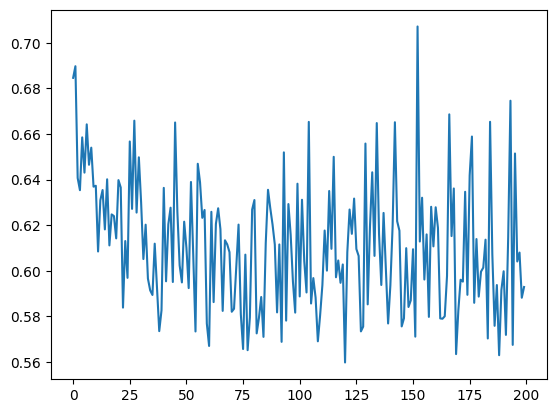

Train Accuracies


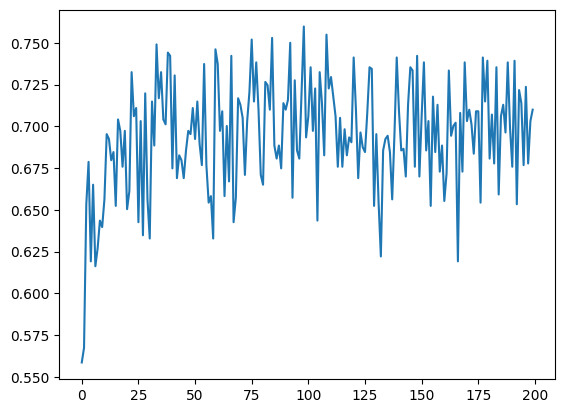

Validation Losses


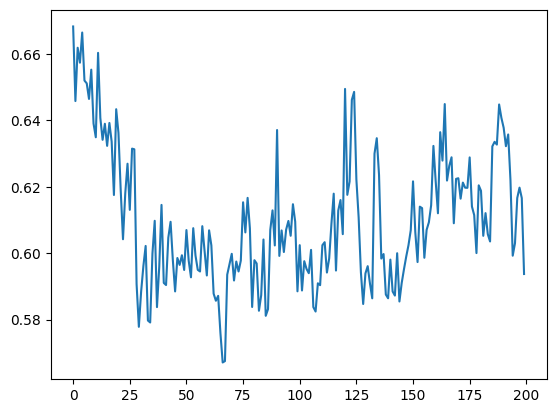

Validation Accuracies


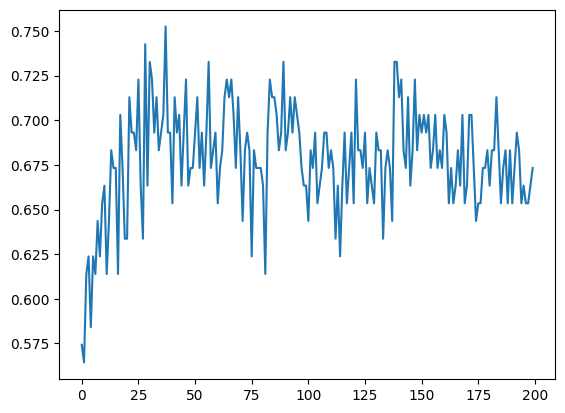

In [9]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [10]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]

Test loss epoch 199:  0.6271137595176697
Test accuracy epoch 199:  0.6696428571428571


## Further Results

We again remind that to have a complete map of all our tests, please look at _experiments.pdf_ in this repository.